In [63]:
import keras
import numpy as np
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from pylab import imread, imshow
from skimage.color import rgb2gray
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, core , UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import helpers
plt.style.use('ggplot')

In [5]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
        padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [6]:
def get_unet(dropout, input_img):
    inputs = input_img
    patch_size = 32
    print("PATCH SIZE", patch_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(inputs)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(up1)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(up2)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_last')(conv5)
    conv6 = core.Reshape((2,32*32))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)
    return model

In [17]:
def get_unet_seismic(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [18]:
def load_images_from_folder(folder_path):
    file_names = os.listdir(folder_path)
    file_names.sort()
    images = []
    for filename in file_names:
        try:
            image =imread(folder_path + filename)
            images.append(rgb2gray(image).reshape(32,32,1))
        except:
            continue
    return images

In [19]:
def generator(x_train, y_train, batch_size):
    data_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True,
    ).flow(x_train, x_train, batch_size, seed=1)
    mask_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True
    ).flow(y_train, y_train, batch_size, seed=1)
    while True:
        x_batch, _ = data_gen.next()
        y_batch, _ = mask_gen.next()
        yield x_batch, y_batch

## Test data augmentation function

In [20]:

X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
image_batch, mask_batch = next(generator(X_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../data/DRIVE/training/patches/'

In [23]:
def train(epochs, n_folds = 5):
    X = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    input_img = Input((32,32,1))
    model = get_unet_seismic(dropout = 0.05, input_img = input_img)
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    batch_size = 32
    historyList =[]
    if n_folds > 0:
        if (len(X) % n_folds) != 0:
            raise Exception('Same eye in validation and traning set, Patches: ', X_train.shape[1], ' Folds', n_folds)
        sizeFold = len(X) // n_folds
        fold_idx = []
        for fold in range(n_folds):
            for curIdx in range(sizeFold):
                fold_idx.append(fold)
        fold_idx = np.array(fold_idx)
    
        for fold in range(n_folds):
            train_idx = fold_idx != 0
            test_idx = fold_idx == 0
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            model.compile(optimizer = opt, loss = 'binary_crossentropy')
            history = model.fit_generator(generator(X_train, y_train, batch_size = batch_size),
                                  epochs = epochs, steps_per_epoch = len(X_train)//batch_size,
                                         validation_data = (X_test,y_test))
            historyList.append(history)
    else : 
        model.compile(optimizer = opt, loss = 'binary_crossentropy')
        history = model.fit_generator(generator(X, y, batch_size = batch_size),
                                      epochs = epochs, steps_per_epoch = len(X)//batch_size)
        historyList.append(history)
    return model, historyList
    

In [ ]:
res, historyList = train(epochs = 40, n_folds = 0)


Epoch 1/40
62/62 [==============================] - 36s 577ms/step - loss: 0.8295
Epoch 2/40
62/62 [==============================] - 29s 472ms/step - loss: 0.6683
Epoch 3/40
62/62 [==============================] - 29s 470ms/step - loss: 0.5974
Epoch 4/40
62/62 [==============================] - 28s 460ms/step - loss: 0.5549
Epoch 5/40
62/62 [==============================] - 28s 453ms/step - loss: 0.5293
Epoch 6/40
62/62 [==============================] - 29s 461ms/step - loss: 0.5133
Epoch 7/40
62/62 [==============================] - 28s 458ms/step - loss: 0.4961
Epoch 8/40
62/62 [==============================] - 29s 464ms/step - loss: 0.4799
Epoch 9/40
62/62 [==============================] - 29s 467ms/step - loss: 0.4654
Epoch 10/40
62/62 [==============================] - 28s 451ms/step - loss: 0.4566
Epoch 11/40
62/62 [==============================] - 31s 492ms/step - loss: 0.4473
Epoch 12/40
62/62 [==============================] - 29s 462ms/step - loss: 0.4405
Epoch 13/40
6

In [50]:
print(historyList)
loss_data = ([i.history['loss'] for i in historyList])
val_loss_data = ([i.history['val_loss'] for i in historyList])
loss_data += val_loss_data
model_history_dataframe = pd.DataFrame(loss_data).T
model_history_dataframe.columns=['fold0_loss', "fold1_loss", "fold0_val_loss", "fold_1_val_loss"]
print(model_history_dataframe)
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.xlabel("epoch")
#plt.ylabel("loss")
#plt.show()


[<keras.callbacks.History object at 0x154afd898>, <keras.callbacks.History object at 0x1585022b0>]
   fold0_loss  fold1_loss  fold0_val_loss  fold_1_val_loss
0    0.688707    0.586872        0.673351         0.678864
1    0.635719    0.537543        0.623475         0.666450


In [ ]:
a = np.array([0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2])
a != 0
fmri = sns.load_dataset("fmri")
ax = sns.lineplot(x="timepoint", y="signal", data=fmri)


NameError: name 'X_train' is not defined

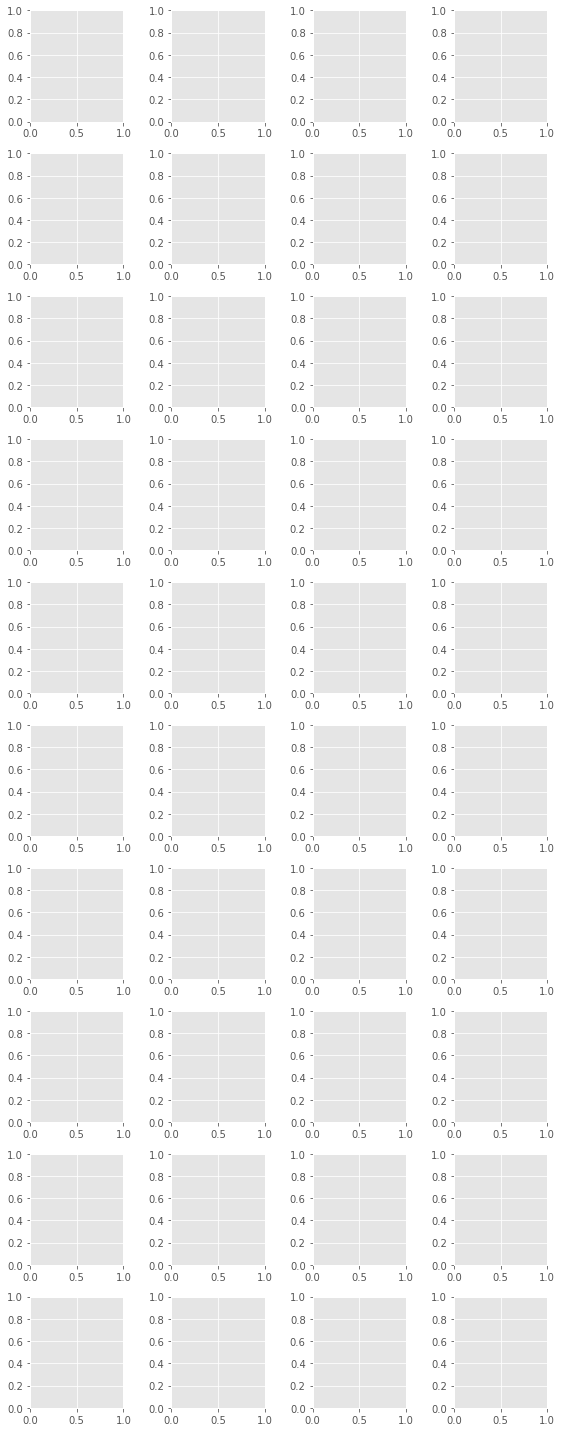

In [86]:
nr_of_images = 10
fig, ax = plt.subplots(nr_of_images,4, figsize=(8,20))
fig.tight_layout()
for image_nr in range(nr_of_images):
    ax[image_nr,0].imshow(X_train[image_nr].reshape(32,32))
    ax[image_nr,1].imshow(y_train[image_nr].reshape(32,32))
    y_pred = res.predict(X_train[image_nr:(image_nr+1)]).reshape(32,32)
    y_pred_thr = y_pred.copy()
    y_pred_thr[y_pred > 0.5] = 1
    y_pred_thr[y_pred <= 0.5] = 0
    ax[image_nr,2].imshow(y_pred)
    ax[image_nr,3].imshow(y_pred_thr)
    for j in range(4):
        ax[image_nr,j].set_xticklabels([])
        ax[image_nr,j].set_yticklabels([])
plt.show()



In [11]:
def segment_image(image, mask, model, m, dataset):
    image = rgb2gray(image)
    patches, indexes = helpers.image_to_non_overlapping_patches(image, mask, m, helpers.Dataset.DRIVE)
    patches = np.array(patches)
    patches = patches.reshape(patches.shape[0], m, m, 1)
    y_pred = model.predict(patches).reshape(patches.shape[0], 32,32)
    y_pred_thr = y_pred.copy()
    y_pred_thr[y_pred > 0.5] = 1
    y_pred_thr[y_pred <= 0.5] = 0
    image = helpers.patches_to_image(y_pred_thr, indexes, m, image.shape[0], image.shape[1] )
    return image

In [58]:
drive_images = helpers.load_images_from_folder(helpers.DRIVE_TEST_IMAGES_PATH)
drive_mask = helpers.load_images_from_folder(helpers.DRIVE_TEST_MASK_PATH)
drive_segmented = helpers.load_images_from_folder(helpers.DRIVE_TEST_SEG_1_PATH)

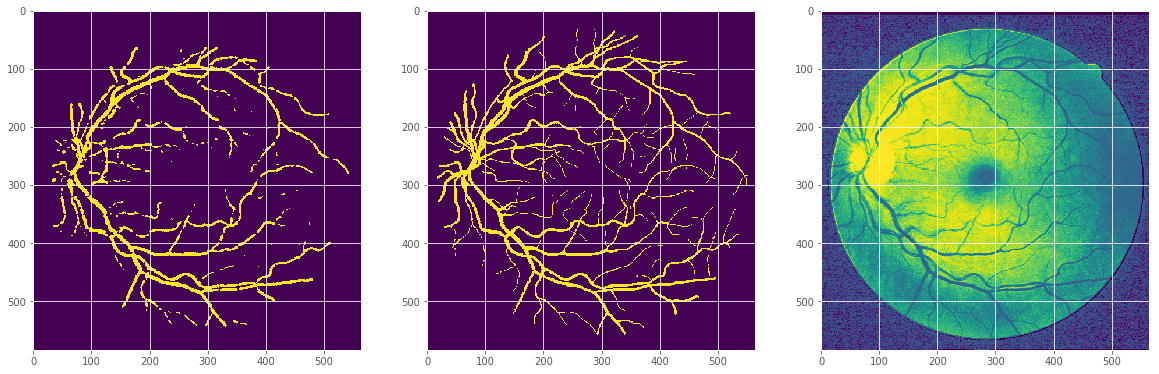

In [60]:
image_segmentation = segment_image(drive_images[0], drive_mask[0], res, 32, helpers.Dataset.DRIVE)
fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(image_segmentation)
ax[1].imshow(drive_segmented[0])
ax[2].imshow(helpers.histogram_equalization(drive_images[0]))

plt.show()

0.8110447093188314